# Feature engineering for Stochastic Data Module

This notebook generates features for the stochastic data (see section ?? of the paper).

The **input** files for this notebook are:

- master list: should be located in the root folder;
- OHLC data for an asset (BTCUSDT in our case): should be located in the root folder. We splitted the data on the weekly basis and concatenated in one data frame while reading the data. We used 15m candlestick data.

The **output** files for this notebook are:

- features data frame: will be placed in the current folder.

<img align="left" width="678" height="344" src="../assets/stochastic_module.png">

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")

from feature_engineering import *
from utils import *

In [4]:
master_list = pd.read_csv('../master_list_v3_DBI.csv')
master_list['close_time'] = pd.to_datetime(master_list['close_time'])
master_list['target'].value_counts()

 0    1645
 1     568
-1     386
Name: target, dtype: int64

# Read the data

In [5]:
# Directory of 15m btcusdt data (splitted weekly)
files = os.listdir(f'../00_data/btcusdt/15m')
files = [f for f in files if f.split('.')[-1] == 'csv']

In [6]:
# GMT+4 time zone
df = pd.DataFrame()
for f in files:
    temp_df = pd.read_csv(f'../00_data/btcusdt/15m/{f}')
    df = pd.concat((df, temp_df))
    
df['open_time'] = pd.to_datetime(df['open_time'])
df['close_time'] = pd.to_datetime(df['close_time'])

df = df.sort_values('open_time').drop(columns=['Unnamed: 0', 'ignore'])

In [7]:
# Merge candlestick data with master list
df = df.merge(master_list, how='left', on='close_time')

# Preprocessing 

### Covariance matrices

Build covariance matrices $K$ for each kernel for each preselected lengthscale and calculate $K^{-\frac{1}{2}}$

In [8]:
inv_cov_dct = get_inv_cov(samp_size=96)

100%|███████████████████████████████████████████| 21/21 [00:02<00:00, 10.26it/s]


# Feature engineering

To test the hypothesis that sample $X = \{x_1, \dots, x_n \}$ is generated be the GP with covariance matrix $K$ we will follow these steps:

1) $X \sim GP(0, K)$ is equivalent to $Y = K^{-\frac{1}{2}} X \sim \mathcal{N}(0, I)$
2) The latter is equivalent to $Y = \{y_1, \dots, y_n \} \sim \mathcal{N}(0, 1)$
3) For this we are using Shapiro-Wilk test

In [9]:
features = feature_engineering_stochastic(df, inv_cov_dct)
features.to_csv('features.csv', index=False)

100%|██████████████████████████████████████| 2599/2599 [00:17<00:00, 151.23it/s]


# ROC-AUC

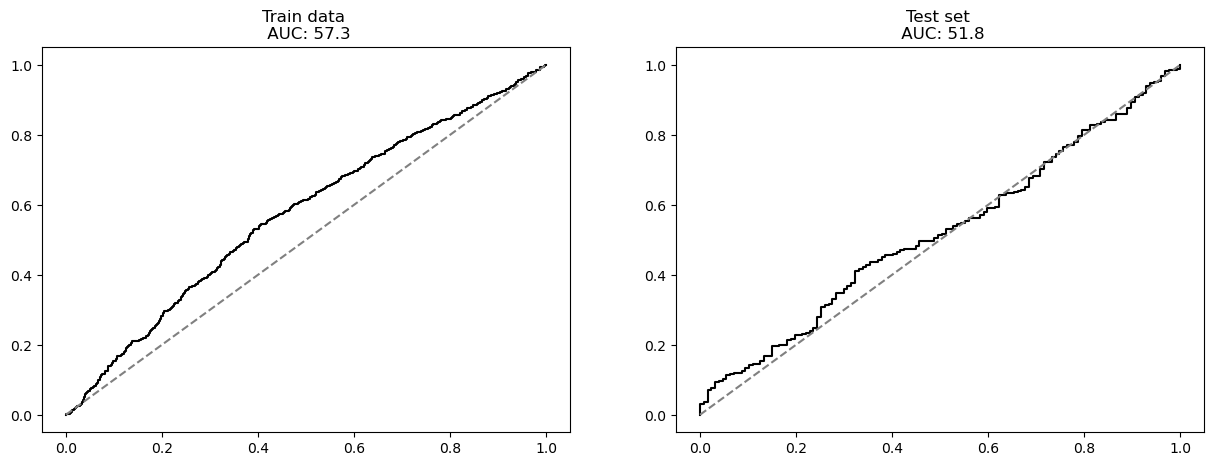

In [10]:
plot_roc_auc(features, 'p_value_SW_Matern32')